<h1>Example: Gibbs Sampling</h1>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:
import numpy             as np
import numpy.linalg      as la
import pyLIQTR.sim_methods.quantum_ops  as  qops 
import matplotlib.pyplot  as plt

import cirq

from pyLIQTR.QSP          import gen_qsp   as   qspFuncs
from pyLIQTR.QSP          import QSP       as   pQSP

from pyLIQTR.QSP.Hamiltonian import Hamiltonian as pyH
from pyLIQTR.QSP.qsp_helpers import qsp_decompose_once 
from   pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform
import resource_analysis as ran
from scipy.optimize import curve_fit as cf
from scipy.stats import linregress as lr

from cirq.contrib.svg import SVGCircuit

import shadow_circuit as sh

<hr>
<h2><u> Circuit Generation </u></h2>
<h3>Background</h3>

This notebook describes how `pyLIQTR` can be used to generate circuits for Gibbs sampling as described in the previous tutorials, as well as some resource analysis. For a full background on Gibbs states, see Tutorial 1a. 

Let us begin by considering an example of a 3-qubit system subject to an XXZ-Heisenberg Hamiltonian. The details behind implementing such a Hamiltonian with `pyLIQTR` can be found in the 'Heisenberg' tutorial. Here, we calculate the Gibbs state for this example.

In [2]:
# Define Hamiltonian as in Heisenberg tutorials, using the XXZ model

# Hamiltonian parameters

N    =    3;       

J_z  =    1.0;

J_x  =    1.1*J_z;     J_y  =   J_x;               
h_x  =   -1.0*J_z;     h_y  =   0.0*J_z;     h_z  =   0.0*J_z;

In [3]:
# Generate input parameter sets
tuples,types,coeffs = qops.params_heisenberg_1d(N,
                                                J_x=J_x,J_y=J_y,J_z=J_z,
                                                h_x=h_x,h_y=h_y,h_z=h_z,
                                                periodic=False)

# Generate Hamiltonian Matrix
H = qops.ham_from_pauli_tuples(tuples,types,coeffs,N)

# Let us define our inverse temperature as beta = 0.5
beta = 0.5

<h3>QSP: Circuit Generation</h3>

In the previous tutorial we having convinced ourselves that QSP is giving a numerically sensible result, so we can procede to construct practical circuits for quantum simulation.   Circuit generation is performed by the `pQSP` class from the   `pyLIQTR` library. We require an input set of tuples that contain Pauli strings for the target Hamiltonian and their corresponding coefficients.  We do this using the `ps_text_full_set(...)` routine, being careful to incorporate our Min-Max rescaling:

In [4]:
# Pre processing for QSP requires Min-Max Rescaling 

evals,evecs = la.eig(H)


e_min = np.min(evals)
e_max = np.max(evals)

e_diff = e_max - e_min

ham_strings = qops.ps_text_full_set(tuples,types,N,Coeffs=coeffs / e_diff)
ham_strings

[('XXI', (0.10504681804825268+0j)),
 ('IXX', (0.10504681804825268+0j)),
 ('YYI', (0.10504681804825268+0j)),
 ('IYY', (0.10504681804825268+0j)),
 ('ZZI', (0.09549710731659333+0j)),
 ('IZZ', (0.09549710731659333+0j)),
 ('XII', (-0.09549710731659333+0j)),
 ('IXI', (-0.09549710731659333+0j)),
 ('IIX', (-0.09549710731659333+0j))]

Now, we generate a QSP sequence for our imaginary timestep, $\tau = \beta(\lambda_{max}-\lambda_{min})/2$. In this case, an internal representation of the target Hamiltonian is generated from Pauli strings using the `pyH(...)` routine:

In [5]:
tau = beta*(e_diff).real/2.0
qsp_H  = pyH(ham_strings)

Which we can then pass as an argument to a separate set of angle generation routines (here we use random angles, as we only investigate circuit generation and scaling analysis):

In [6]:
required_precision = 1e-6

#Old, deprecated call:
#angles, tolerances = qspFuncs.get_phis(qsp_H, simtime=dt*sclf, 
#                                       req_prec=required_precision);
angles, tolerances = qspFuncs.compute_hamiltonian_angles(qsp_H,simtime=tau, req_prec=required_precision,\
                                        mode="random")

Next, we need to initialize a circuit which applies our random clifford unitary before passing it to our QSP procedure. With the required phase angles and Hamiltonian in hand, we can use the `QSP` class (imported here as `pQSP`) to construct the second part of the circuit. Finally, we initialize a circuit which applies our final random clifford unitary for random measurement, and concatenate the three:

In [7]:
# Initialize circuit to the correct size
qsp_generator = pQSP.QSP(phis=angles, hamiltonian=qsp_H, 
                         target_size=qsp_H.problem_size)

# Add initial random unitary for random pure state preperation
rand_u = sh.random_unitary_circ(0.1, qsp_generator.target)

# Add QSP circuit
qsp_circ = qsp_generator.circuit()

# Add random Pauli measurement for classical shadows
rand_p = sh.random_pauli_circ(qsp_generator.target)

tot_circ = cirq.Circuit()
tot_circ.append(rand_u)
tot_circ.append(qsp_circ)
tot_circ.append(rand_p)


<hr>
<h2>Full Circuit and its Components</h2>

The output is a standard `cirq` circuit. We can print this to see the full circuit that a single shadow in our algorithm would require, inlcuding a high-level organization of the QSP Sequence:

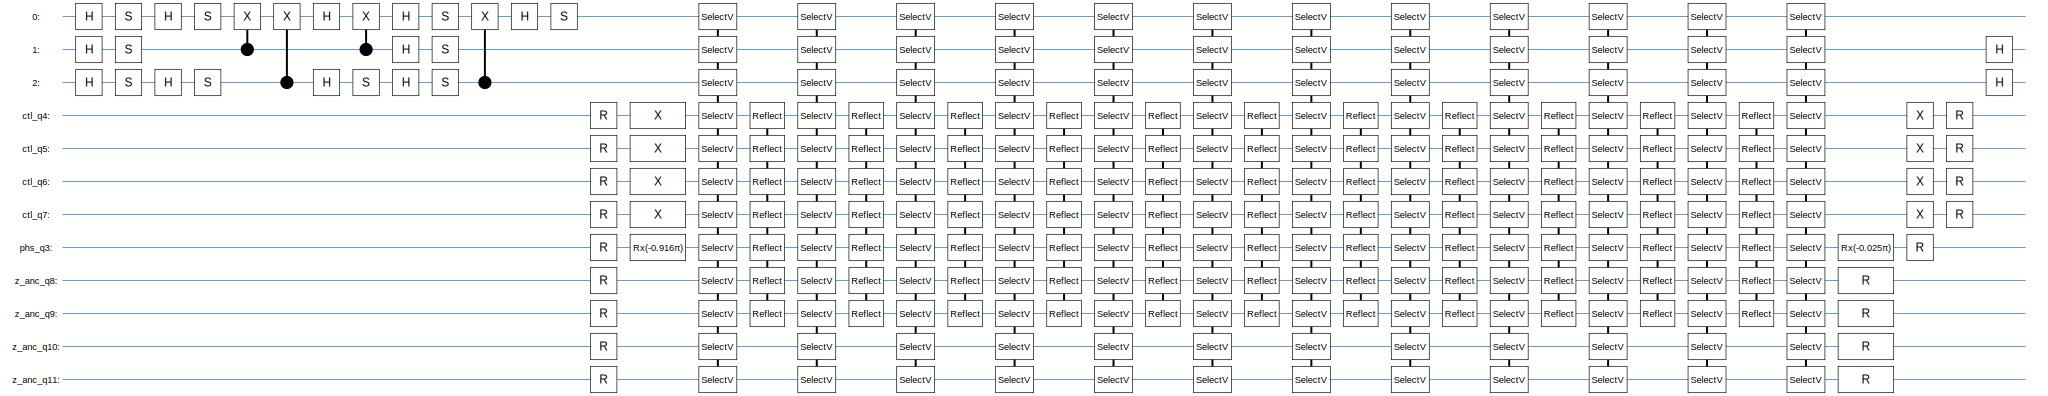

In [ ]:
tot_circ
SVGCircuit(tot_circ)

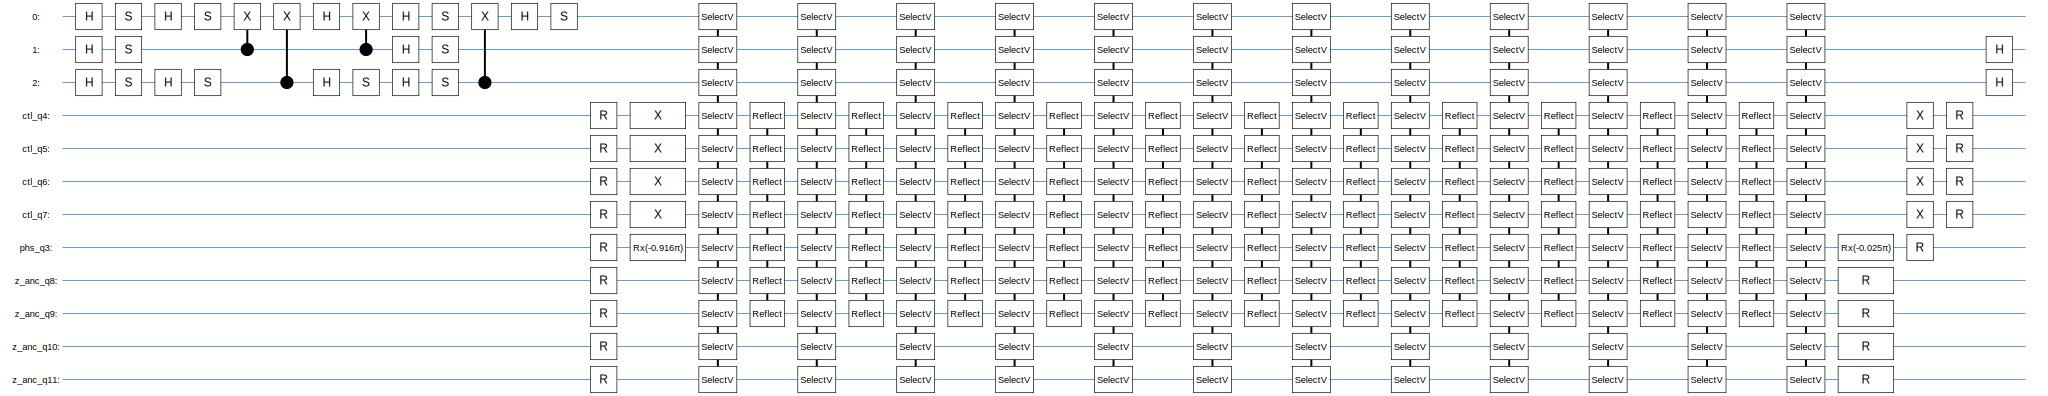

In [8]:
tot_circ
SVGCircuit(tot_circ)

Or decompose the circuit to see constituents of the `SelectV` and `Reflect` unitaries.

The following cell shows how these unitaries are further broken down into `SelectVBase`, `Prepare` and a `MultiCZ` operators of QSP, alongsite rotation gates that apply the rotation prescribed by the angle calculation.

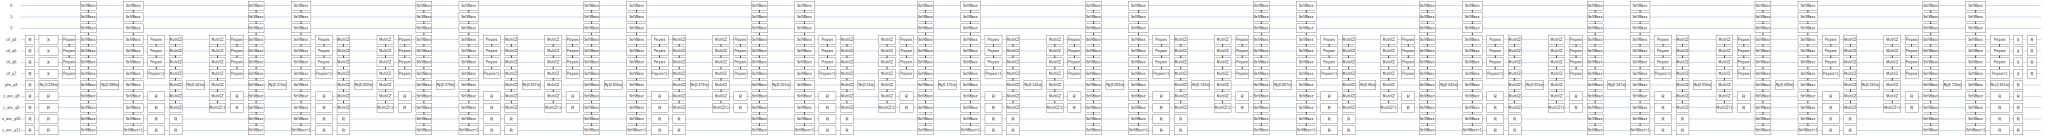

In [23]:
# Decompose QSP part of circuit once
decomposed_once_qsp = cirq.align_left((qsp_decompose_once(qsp_circ)))
SVGCircuit(decomposed_once_qsp)

We can then further decompose the operators into controlled operations and one qubit gates (we note, that this is not a unique construction for the above operators, but these are fairly efficient ones). Also note that we can decompose and analyze single blocks of selv-prep and multicz before scaling them up.

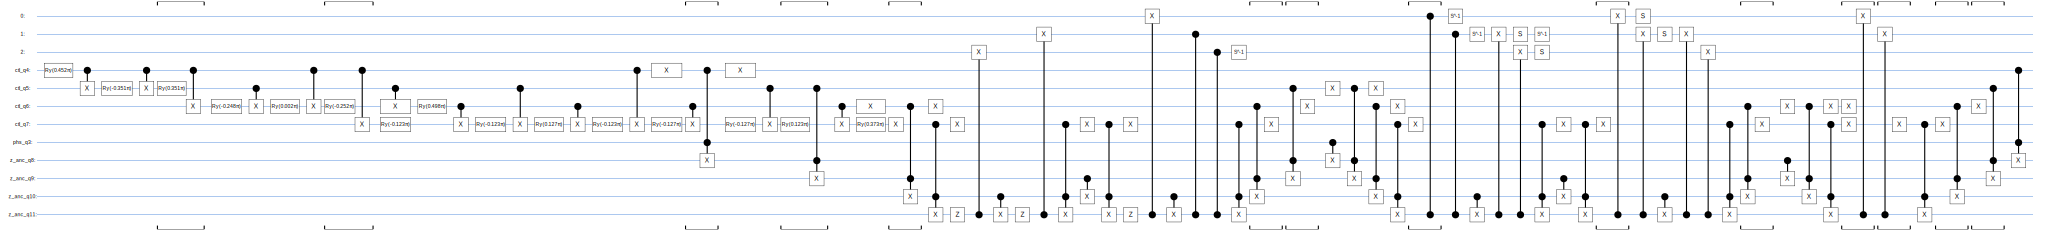

In [24]:
selv_prep = decomposed_once_qsp[2:4]
selv_prep_cops = cirq.align_left(qsp_decompose_once(selv_prep))
SVGCircuit(selv_prep_cops)

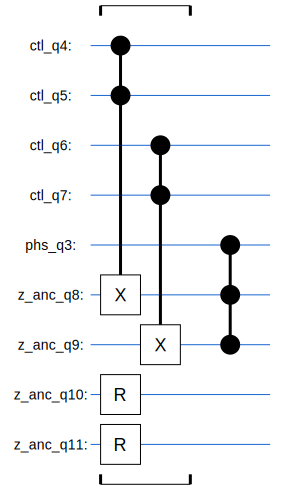

In [25]:
multiCZ = decomposed_once_qsp[7:8]
multiCZ_cops = cirq.align_left(qsp_decompose_once(multiCZ))
SVGCircuit(multiCZ_cops)

It is also useful to separate out and decompose the parts of the circuit not used for QSP, i.e. the random unitaries and random pauli basis measurements.

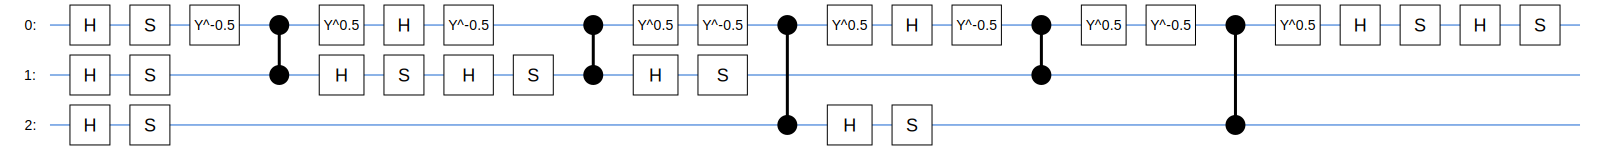

In [26]:
rand_u_cops = cirq.align_left(qsp_decompose_once(rand_u))
SVGCircuit(rand_u_cops)

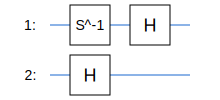

In [13]:
SVGCircuit(rand_p)

<hr>
<h2> NISQ Circuit Decomposition and Resource Estimation </h2>

To perform out resource estimation and scaling analysis, we need to further decompose the circuit blocks generated above. However, the way in which we do so is not agnostic to hardware. For NISQ devices, it is reasonable to decompose our circuit into one and two qubit gates, including rotation gates.  

In [14]:
nisq_selvprep = sh.nisq_decomp(selv_prep_cops)
nisq_multiCZ = sh.nisq_decomp(multiCZ_cops)

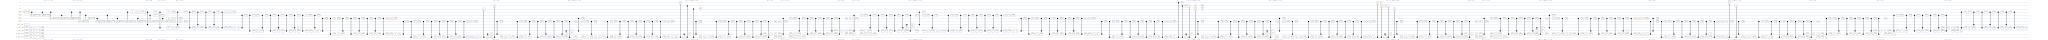

In [15]:
SVGCircuit(nisq_selvprep)

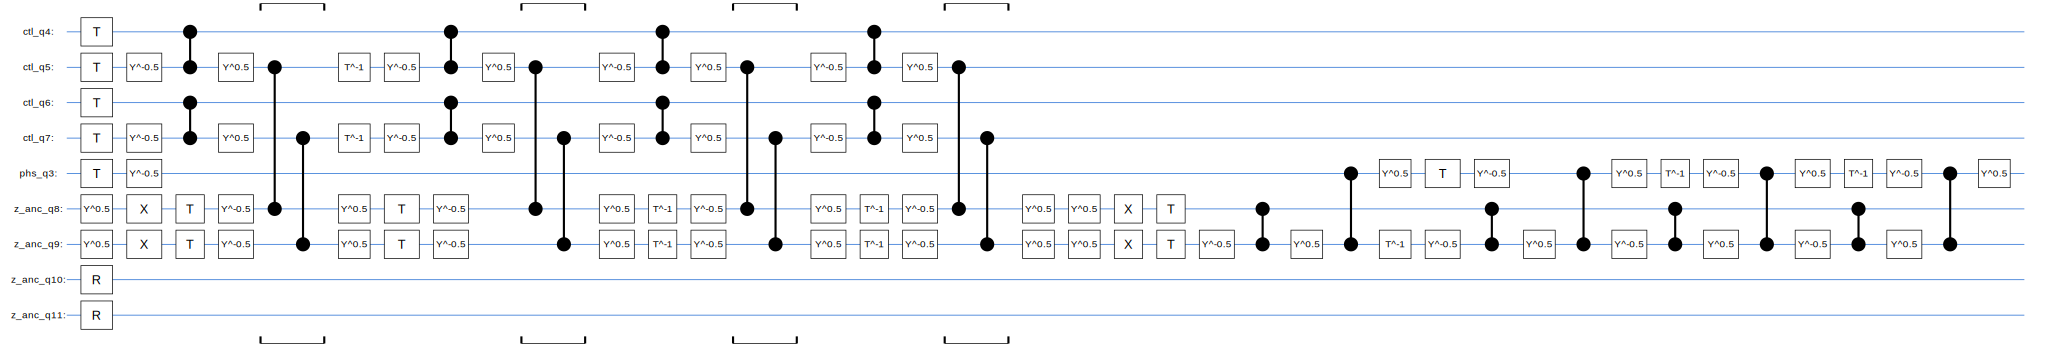

In [16]:
SVGCircuit(nisq_multiCZ)

In [17]:
import resource_analysis as ran

sevlprep_nisq_nt, selvprep_nisq_ntiv = ran.get_t_counts(nisq_selvprep)
selvprep_nisq_depth = ran.get_gate_depth(nisq_selvprep)

multiCZ_nisq_nt, multiCZ_nisq_ntiv = ran.get_t_counts(nisq_multiCZ)
multiCZ_nisq_depth = ran.get_gate_depth(nisq_multiCZ)

randu_nisq_nt, randu_nisq_ntiv = ran.get_t_counts(rand_u_cops)
randu_nisq_depth = ran.get_gate_depth(rand_u_cops)

randp_nisq_nt, randp_nisq_ntiv = ran.get_t_counts(rand_p)
randp_nisq_depth = ran.get_gate_depth(rand_p)

In [18]:
print()
print("NISQ Resource Estimation")
print("Prepare + Select\n================================")
print(" Depth:\t", selvprep_nisq_depth)
print(" T Count:\t\t", sevlprep_nisq_nt)
print(" T^dag Count:\t\t", selvprep_nisq_ntiv)
print(" T Total:\t\t", sevlprep_nisq_nt + selvprep_nisq_ntiv)

print("\n")
print("MultiCZ\n================================")
print(" Depth:\t", multiCZ_nisq_depth)
print(" T Count:\t\t", multiCZ_nisq_nt)
print(" T^dag Count:\t\t", multiCZ_nisq_ntiv)
print(" T Total:\t\t", multiCZ_nisq_nt + multiCZ_nisq_ntiv)

print("\n")
print("Random Unitary Circuit\n================================")
print(" Depth:\t", randu_nisq_depth)
print(" T Count:\t\t", randu_nisq_nt)
print(" T^dag Count:\t\t", randu_nisq_ntiv)
print(" T Total:\t\t", randu_nisq_nt + randu_nisq_ntiv)

print("\n")
print("Random Pauli Basis Measurement\n================================")
print(" Depth:\t", randp_nisq_depth)
print(" T Count:\t\t", randp_nisq_nt)
print(" T^dag Count:\t\t", randp_nisq_ntiv)
print(" T Total:\t\t", randp_nisq_nt + randp_nisq_ntiv)


NISQ Resource Estimation
Prepare + Select
 Depth:	 468
 T Count:		 88
 T^dag Count:		 66
 T Total:		 154


MultiCZ
 Depth:	 40
 T Count:		 12
 T^dag Count:		 9
 T Total:		 21


Random Unitary Circuit
 Depth:	 16
 T Count:		 0
 T^dag Count:		 0
 T Total:		 0


Random Pauli Basis Measurement
 Depth:	 2
 T Count:		 0
 T^dag Count:		 0
 T Total:		 0


<hr>
<h2>FT Circuit Decomposition and Resource Estimation</h2>

For Fault Tolerant hardware, we need to decompose the circuit into only Clifford + T gates.

In [19]:
from   pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform

selvprep_cliff_t = cirq.align_left(clifford_plus_t_direct_transform(selv_prep_cops))
multiCZ_cliff_t = cirq.align_left(clifford_plus_t_direct_transform(multiCZ_cops))

randu_cliff_t = cirq.align_left(clifford_plus_t_direct_transform(rand_u))
randp_cliff_t = cirq.align_left(clifford_plus_t_direct_transform(rand_p))

In [20]:
SVGCircuit(selvprep_cliff_t)

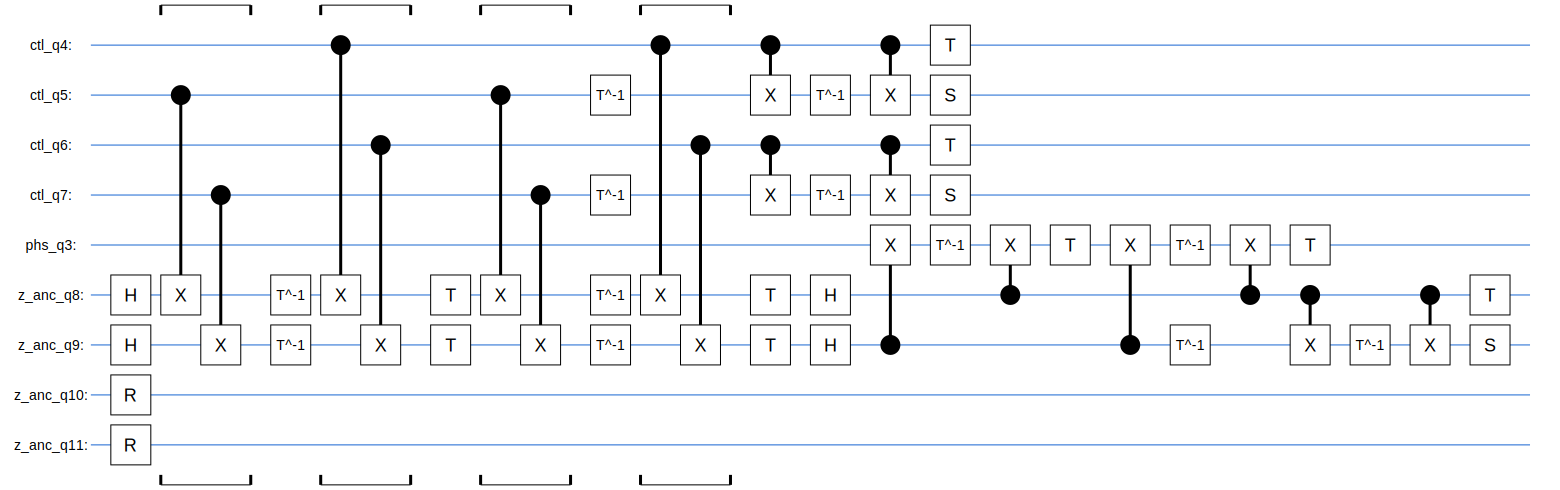

In [21]:
SVGCircuit(multiCZ_cliff_t)

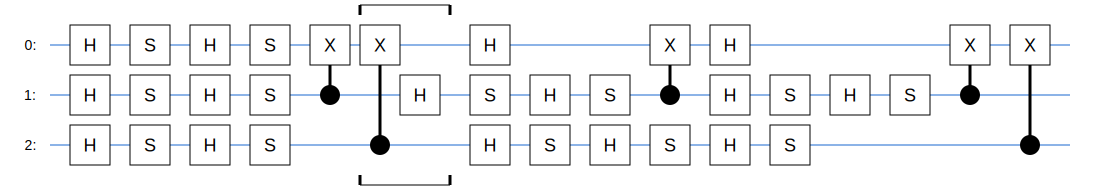

In [22]:
SVGCircuit(randu_cliff_t)

In [23]:
sevlprep_ct_nt, selvprep_ct_ntiv = ran.get_t_counts(selvprep_cliff_t)
selvprep_ct_depth = ran.get_gate_depth(selvprep_cliff_t)

multiCZ_ct_nt, multiCZ_ct_ntiv = ran.get_t_counts(multiCZ_cliff_t)
multiCZ_ct_depth = ran.get_gate_depth(multiCZ_cliff_t)

randu_ct_nt, randu_ct_ntiv = ran.get_t_counts(randu_cliff_t)
randu_ct_depth = ran.get_gate_depth(randu_cliff_t)

randp_ct_nt, randp_ct_ntiv = ran.get_t_counts(randp_cliff_t)
randp_ct_depth = ran.get_gate_depth(randp_cliff_t)

In [24]:
print()
print("Fault Tolerant Resource Estimation")
print("Prepare + Select\n================================")
print(" Clifford+T Depth:\t", selvprep_ct_depth)
print(" T Count:\t\t", sevlprep_ct_nt)
print(" T^dag Count:\t\t", selvprep_ct_ntiv)
print(" T Total:\t\t", sevlprep_ct_nt + selvprep_ct_ntiv)

print("\n")
print("MultiCZ\n================================")
print(" Clifford+T Depth:\t", multiCZ_ct_depth)
print(" T Count:\t\t", multiCZ_ct_nt)
print(" T^dag Count:\t\t", multiCZ_ct_ntiv)
print(" T Total:\t\t", multiCZ_ct_nt + multiCZ_ct_ntiv)

print("\n")
print("Random Unitary Circuit\n================================")
print(" Clifford+T Depth:\t", randu_ct_depth)
print(" T Count:\t\t", randu_ct_nt)
print(" T^dag Count:\t\t", randu_ct_ntiv)
print(" T Total:\t\t", randu_ct_nt + randu_ct_ntiv)

print("\n")
print("Random Pauli Basis Measurement\n================================")
print(" Clifford+T Depth:\t", randp_ct_depth)
print(" T Count:\t\t", randp_ct_nt)
print(" T^dag Count:\t\t", randp_ct_ntiv)
print(" T Total:\t\t", randp_ct_nt + randp_ct_ntiv)


Fault Tolerant Resource Estimation
Prepare + Select
 Clifford+T Depth:	 3540
 T Count:		 1564
 T^dag Count:		 88
 T Total:		 1652


MultiCZ
 Clifford+T Depth:	 21
 T Count:		 9
 T^dag Count:		 12
 T Total:		 21


Random Unitary Circuit
 Clifford+T Depth:	 16
 T Count:		 0
 T^dag Count:		 0
 T Total:		 0


Random Pauli Basis Measurement
 Clifford+T Depth:	 2
 T Count:		 0
 T^dag Count:		 0
 T Total:		 0


In [25]:
from   pyLIQTR.QSP.qsp_helpers import qsp_decompose_once, print_to_openqasm, prettyprint_qsp_to_qasm 

#Write it.
import time
t0 = time.time()
with open('selvprep_cliff_t_N{}.qasm'.format(N),'w') as f:
    print_to_openqasm(f, selvprep_cliff_t)
t1 = time.time()
with open('multiCZ_cliff_t_N{}_CpT.qasm'.format(N),'w') as f:
    print_to_openqasm(f, multiCZ_cliff_t)
t2 = time.time()
with open('randu_cliff_t_N{}_CpT.qasm'.format(N),'w') as f:
    print_to_openqasm(f, randu_cliff_t)
t3 = time.time()
with open('randp_cliff_t_N{}_CpT.qasm'.format(N),'w') as f:
    print_to_openqasm(f, randp_cliff_t)
t4 = time.time()
print("OPENQASM time = {} {} {} {}".format(t1-t0, t2-t1, t3-t2, t4-t3))

OPENQASM time = 0.13416457176208496 0.0 0.0 0.015902042388916016


In [26]:
from   pyLIQTR.QSP.qsp_helpers import qsp_decompose_once, print_to_openqasm, prettyprint_qsp_to_qasm 

#Write it.
import time
t0 = time.time()
with open('selvprep_cliff_t_N{}.qasm'.format(N),'w') as f:
    print_to_openqasm(f, selvprep_cliff_t)
t1 = time.time()
with open('multiCZ_cliff_t_N{}_CpT.qasm'.format(N),'w') as f:
    print_to_openqasm(f, multiCZ_cliff_t)
t2 = time.time()
with open('randu_cliff_t_N{}_CpT.qasm'.format(N),'w') as f:
    print_to_openqasm(f, randu_cliff_t)
t3 = time.time()
with open('randp_cliff_t_N{}_CpT.qasm'.format(N),'w') as f:
    print_to_openqasm(f, randp_cliff_t)
t4 = time.time()
print("OPENQASM time = {} {} {} {}".format(t1-t0, t2-t1, t3-t2, t4-t3))

OPENQASM time = 0.10578751564025879 0.0 0.0 0.0


<hr>
<h2>Resource Analysis</h2>

Now, we want to analyze how resources will scale with system size, i.e. how costly will a circuit to produce a classical shadow in this algorithm be for larger numbers of qubits? Here, we investigate this question in terms of the <b>circuit depth</b>.

First, let us consider the different components of the circuit: random unitary, qsp sequence, and random pauli basis measurement. For the random pauli basis measurement, for any given qubit we apply either no gates (Z Basis), 1 $H$ gate (X basis) or a $S^{\dagger}$ gate and $H$ gate (Y basis). Thus, as system size increases, the depth of this component will converge to 2, which will turn out to be negligible when compared to the others. 

<h3>NISQ</h3>

We begin with generating nisq-decomposed circuits and analyzing their depths with system size.

<h4>Random Unitary Generator</h4>

For the random unitary generator, we characterize the depth for a given system size by generating several random circuits and taking the mean depth of these. Moreover, from Dankert et al we know that the depth should scale like $O(\text{log}(n)\text{log}(1/\varepsilon))$, which for a fixed $\varepsilon$ is simply logarthmic scaling with system size. Accordingly, we fit average depths for each system size to a logarthmic function to predict circuit depth for arbitrary system sizes.

The mean depth and standard deviation usually converge with about 1000 samples, and form a fairly normal distribution. Thus, for each system size we generate 1000 circuits and use their mean depth as our data point.

In [2]:
from   pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform

# Initial random unitary for random pure state preperation
depths = []
for i in range(1000):
    rand_u = sh.random_unitary_circ(0.1, qsp_generator.target)
    rand_u_nisq = sh.nisq_decomp(rand_u)
    randu_depth = ran.get_gate_depth(rand_u_nisq)
    depths.append(randu_depth)
plt.hist(depths)
plt.show()
print(np.mean(depths))
print(np.std(depths))

NameError: name 'qsp_generator' is not defined

In [3]:
sizes = [3, 10, 17, 24, 31]
means = []
std_errors = []

for n in sizes:
    print(n)
    qubits = cirq.LineQubit.range(n)
    depths = []
    for i in range(1000):
        rand_u = sh.random_unitary_circ(0.1, qubits)
        rand_u_nisq = sh.nisq_decomp(rand_u)
        rand_u_depth = ran.get_gate_depth(rand_u_nisq)
        depths.append(rand_u_depth)
    means.append(np.mean(depths))
    std_errors.append(np.std(depths)/np.sqrt(len(depths)))

3
10
17
24
31


In [4]:
# Empirically determined expression for circuit depth
def f(x, a,b):
    return a*np.log2(x) + b

popt, pcov = cf(f, sizes, means)

print(popt)

[15.77945795 -0.44715543]


C:\Users\arnav\AppData\Local\Temp\ipykernel_62444\3720147576.py:3: RuntimeWarning: divide by zero encountered in log2
  return a*np.log2(x) + b


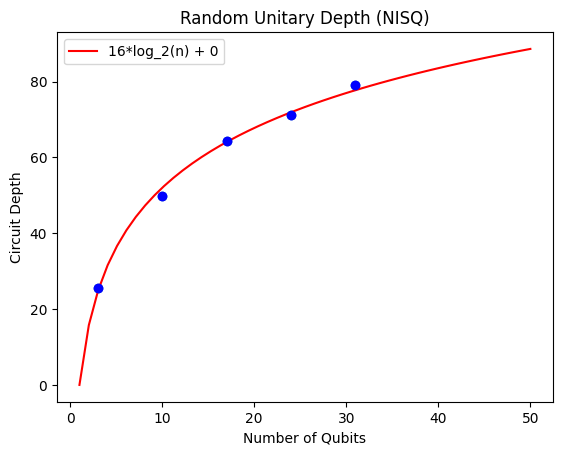

In [5]:
test = np.linspace(0, 50, 50)
plt.scatter(sizes, means)
plt.errorbar(sizes, means, yerr=std_errors, color='blue', fmt='o')
plt.plot(test, f(test, *popt), color='red', label='{}*log_2(n) + {}'.format(*np.rint(popt).astype(int)))
plt.legend()
plt.xlabel('Number of Qubits')
plt.ylabel('Circuit Depth')
plt.title('Random Unitary Depth (NISQ)')
plt.show()

<h4>QSP Blocks</h4>

In [6]:
sizes = [3, 5, 7, 9, 12]
sp_depths = []
sp_2 = []

mcz_2 = []
mcz_depths = []

for size in sizes:
    print(size)
    raw_circ = sh.prep_qsp('XXZ', size, 0.5)
    decomposed_once_qsp = cirq.align_left((qsp_decompose_once(raw_circ)))

    selv_prep = decomposed_once_qsp[2:4]
    selv_prep_cops = cirq.align_left((qsp_decompose_once(selv_prep)))
    nisq_sp = sh.nisq_decomp(selv_prep_cops)
    sp_depths.append(ran.get_gate_depth(nisq_sp))
    sp_2.append(ran.get_2_counts(nisq_sp))

    multiCZ = decomposed_once_qsp[7:8]
    multiCZ_cops = cirq.align_left((qsp_decompose_once(multiCZ)))
    nisq_mcz = sh.nisq_decomp(multiCZ_cops)
    mcz_depths.append(ran.get_gate_depth(nisq_mcz))
    mcz_2.append(ran.get_2_counts(nisq_mcz))

3
5
7
9
12


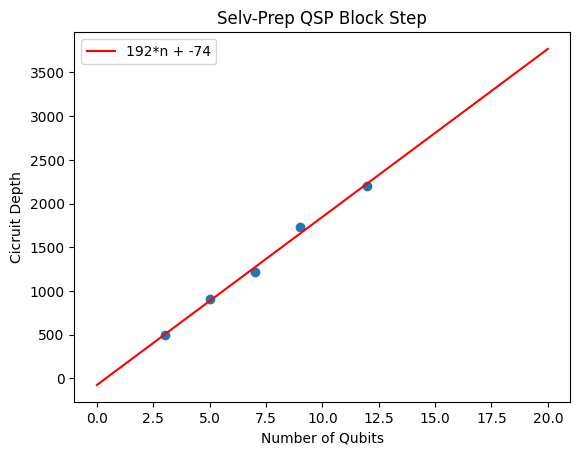

In [7]:
fit = lr(sizes, sp_depths)
test = np.linspace(0, 20, 20)
plt.plot(test, test*fit.slope+fit.intercept, color='red', label='{}*n + {}'.format(np.rint(fit.slope).astype(int), np.rint(fit.intercept).astype(int) ))
plt.legend()
plt.scatter(sizes, sp_depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Cicruit Depth')
plt.title('Selv-Prep QSP Block Step')
plt.show()

<hr>

In [19]:
temps = np.linspace(0.5, 10.5, 11)
sp_depths = []
sp_2 = []

mcz_2 = []
mcz_depths = []

for temp in temps:
    print(temp)
    raw_circ = sh.prep_qsp('XXZ', 12, temp)
    decomposed_once_qsp = cirq.align_left((qsp_decompose_once(raw_circ)))

    selv_prep = decomposed_once_qsp[2:4]
    selv_prep_cops = cirq.align_left((qsp_decompose_once(selv_prep)))
    nisq_sp = sh.nisq_decomp(selv_prep_cops)
    sp_depths.append(ran.get_gate_depth(nisq_sp))
    sp_2.append(ran.get_2_counts(nisq_sp))

    multiCZ = decomposed_once_qsp[7:8]
    multiCZ_cops = cirq.align_left((qsp_decompose_once(multiCZ)))
    nisq_mcz = sh.nisq_decomp(multiCZ_cops)
    mcz_depths.append(ran.get_gate_depth(nisq_mcz))
    mcz_2.append(ran.get_2_counts(nisq_mcz))

0.5
1.5
2.5
3.5
4.5
5.5
6.5
7.5
8.5
9.5
10.5


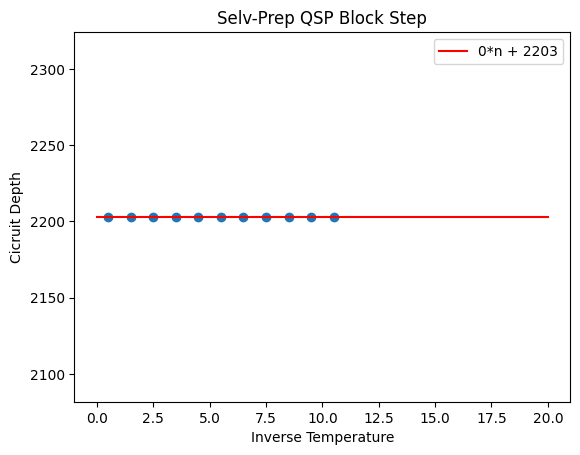

In [20]:
fit = lr(temps, sp_depths)
test = np.linspace(0, 20, 20)
plt.plot(test, test*fit.slope+fit.intercept, color='red', label='{}*n + {}'.format(np.rint(fit.slope).astype(int), np.rint(fit.intercept).astype(int) ))
plt.legend()
plt.scatter(temps, sp_depths)
plt.xlabel('Inverse Temperature')
plt.ylabel('Cicruit Depth')
plt.title('Selv-Prep QSP Block Step')
plt.show()

<hr>

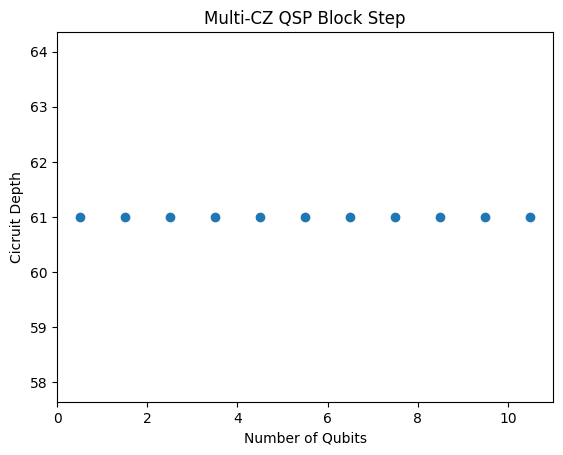

In [21]:
plt.scatter(temps, mcz_depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Cicruit Depth')
plt.title('Multi-CZ QSP Block Step')
plt.show()

<h4> Totals </h4>

3
5
7
9
12


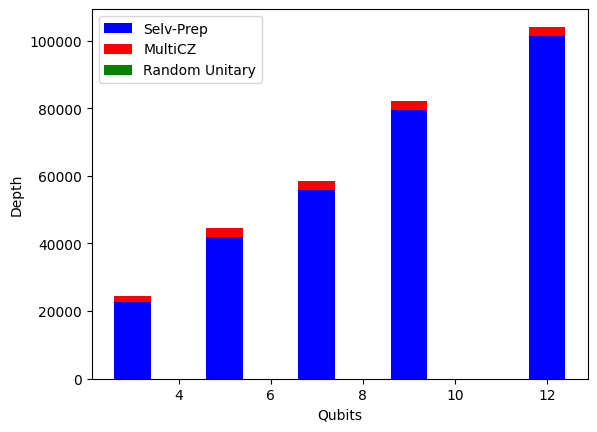

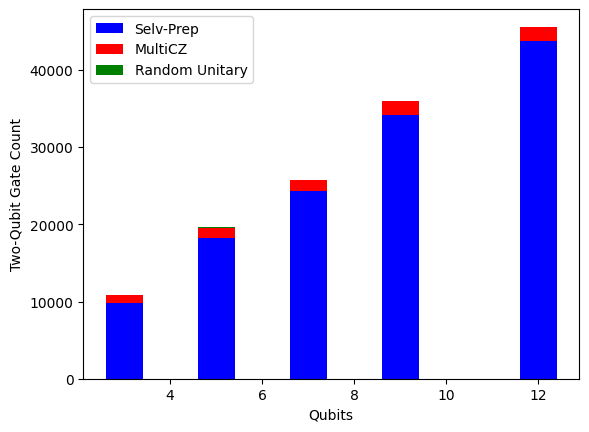

In [7]:
sizes = [3, 5, 7, 9, 12]
mean_d = []
mean_2g = []
#redo random unitary for smaller sizes
for n in sizes:
    print(n)
    qubits = cirq.LineQubit.range(n)
    depths = []
    two_gates = []
    for i in range(1000):
        rand_u = sh.random_unitary_circ(0.1, qubits)
        rand_u_nisq = sh.nisq_decomp(rand_u)

        rand_u_depth = ran.get_gate_depth(rand_u_nisq)
        depths.append(rand_u_depth)

        rand_u_2 = ran.get_2_counts(rand_u_nisq)
        two_gates.append(rand_u_2)
    
    mean_d.append(np.mean(depths))
    mean_2g.append(np.mean(two_gates))

# Multiply Selv-Prep by n_phi - 1 = 46, and MultiCZ by n_phi - 3 = 44 for 24 degree polynomial
sd_full = np.multiply(sp_depths, 46)
mczd_full = np.multiply(mcz_depths, 44)
plt.bar(sizes, sd_full, color='blue')
plt.bar(sizes, mczd_full, bottom=sd_full, color='red')
plt.bar(sizes, mean_d, bottom=np.add(sd_full, mczd_full), color='green')
plt.xlabel('Qubits')
plt.ylabel('Depth')
plt.legend(['Selv-Prep', 'MultiCZ', 'Random Unitary'])
plt.show()

# Two Qubit Gate count
s2_full = np.multiply(sp_2, 46)
mcz2_full = np.multiply(mcz_2, 44)
plt.bar(sizes, s2_full, color='blue')
plt.bar(sizes, mcz2_full, bottom=s2_full, color='red')
plt.bar(sizes, mean_2g, bottom=np.add(s2_full, mcz2_full), color='green')
plt.xlabel('Qubits')
plt.ylabel('Two-Qubit Gate Count')
plt.legend(['Selv-Prep', 'MultiCZ', 'Random Unitary'])
plt.show()



<h3>Fault Tolerant</h3>
<h4>Random Unitary Generator</h4>

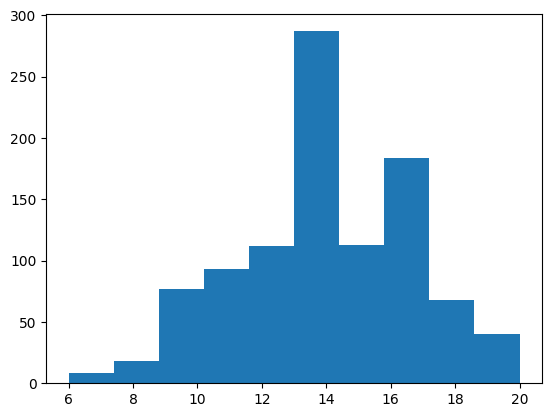

13.889
2.719315906620634


In [34]:
import resource_analysis as ran

# Initial random unitary for random pure state preperation
depths = []
for i in range(1000):
    rand_u = sh.random_unitary_circ(0.1, qsp_generator.target)
    randu_cliff_t = cirq.align_left(clifford_plus_t_direct_transform(rand_u))

    randu_ct_depth = ran.get_gate_depth(randu_cliff_t)
    depths.append(randu_ct_depth)
plt.hist(depths)
plt.show()
print(np.mean(depths))
print(np.std(depths))

In [35]:
from   pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform
import resource_analysis as ran
sizes = [3, 10, 17, 24, 31]
means = []
std_errors = []

for n in sizes:
    print(n)
    qubits = cirq.LineQubit.range(n)
    depths = []
    for i in range(1000):
        rand_u = sh.random_unitary_circ(0.1, qubits)
        rand_u_cops = cirq.align_left(qsp_decompose_once(qsp_decompose_once(rand_u)))
        randu_cliff_t = cirq.align_left(clifford_plus_t_direct_transform(rand_u_cops))

        randu_ct_depth = ran.get_gate_depth(randu_cliff_t)
        depths.append(randu_ct_depth)
    means.append(np.mean(depths))
    std_errors.append(np.std(depths)/np.sqrt(len(depths)))

3
10
17
24
31


In [36]:
# Empirically determined expression for circuit depth
from scipy.optimize import curve_fit as cf

def f(x, a,b):
    return a*np.log2(x) + b

popt, pcov = cf(f, sizes, means)

print(popt)

[ 52.00329733 -30.65994955]


C:\Users\AR32399\AppData\Local\Temp\2\ipykernel_57008\643617486.py:5: RuntimeWarning: divide by zero encountered in log2
  return a*np.log2(x) + b


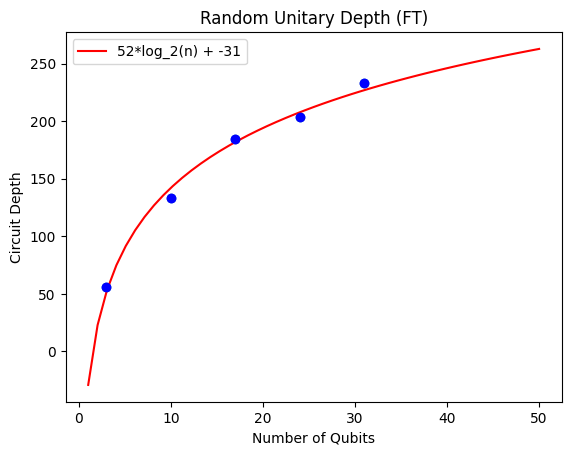

In [37]:
test = np.linspace(0, 50, 50)
plt.scatter(sizes, means)
plt.errorbar(sizes, means, yerr=std_errors, color='blue', fmt='o')
plt.plot(test, f(test, *popt), color='red', label='{}*log_2(n) + {}'.format(*np.rint(popt).astype(int)))
plt.legend()
plt.xlabel('Number of Qubits')
plt.ylabel('Circuit Depth')
plt.title('Random Unitary Depth (FT)')
plt.show()

In [42]:
sizes = [3, 5, 7, 9, 12]
sp_depths = []
sp_t = []

mcz_depths = []
mcz_t = []

for size in sizes:
    print(size)
    raw_circ = sh.prep_qsp('XXZ', size, 0.5)
    decomposed_once_qsp = cirq.align_left((qsp_decompose_once(raw_circ)))

    selv_prep = decomposed_once_qsp[2:4]
    selv_prep_cops = cirq.align_left((qsp_decompose_once(selv_prep)))
    ft_sp = clifford_plus_t_direct_transform(selv_prep_cops)
    sp_t.append(ran.get_t_counts(ft_sp))
    sp_depths.append(ran.get_gate_depth(ft_sp))

    multiCZ = decomposed_once_qsp[7:8]
    multiCZ_cops = cirq.align_left((qsp_decompose_once(multiCZ)))
    ft_mcz = clifford_plus_t_direct_transform(multiCZ_cops)
    mcz_t.append(ran.get_t_counts(ft_mcz))
    mcz_depths.append(ran.get_gate_depth(ft_mcz))

3
5
7
9
12


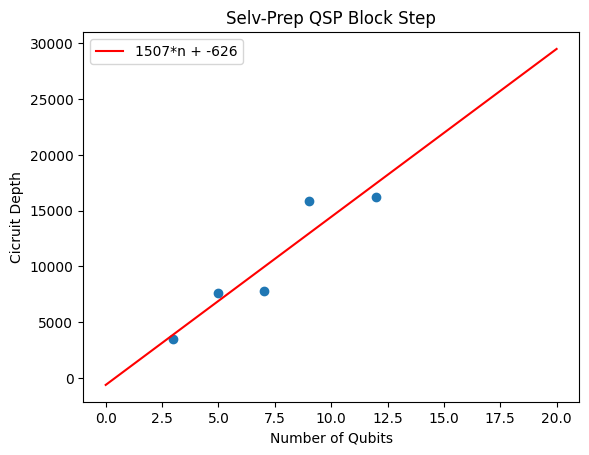

In [39]:
fit = lr(sizes, sp_depths)
test = np.linspace(0, 20, 20)
plt.plot(test, test*fit.slope+fit.intercept, color='red', label='{}*n + {}'.format(np.rint(fit.slope).astype(int), np.rint(fit.intercept).astype(int) ))
plt.legend()
plt.scatter(sizes, sp_depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Cicruit Depth')
plt.title('Selv-Prep QSP Block Step')
plt.show()

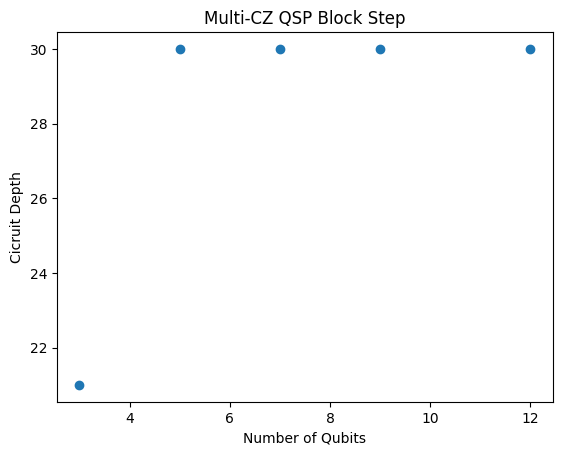

In [40]:
plt.scatter(sizes, mcz_depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Cicruit Depth')
plt.title('Multi-CZ QSP Block Step')
plt.show()

<h4>Totals</h4>

In [45]:
print(sp_t)

[(1562, 88), (3216, 160), (3294, 216), (6538, 296), (6636, 384)]


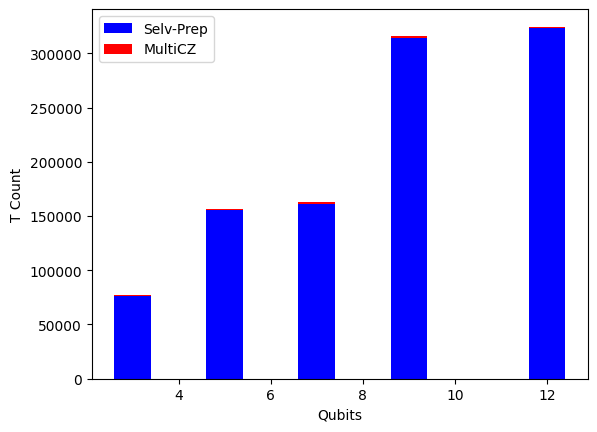

In [46]:
#T Counts
# Multiply Selv-Prep by n_phi - 1 = 46, and MultiCZ by n_phi - 3 = 44 for 24 degree polynomial
st_full = [46*sum(t) for t in sp_t]
mczt_full = [44*sum(t) for t in mcz_t]
plt.bar(sizes, st_full, color='blue')
plt.bar(sizes, mczt_full, bottom=st_full, color='red')
plt.xlabel('Qubits')
plt.ylabel('T Count')
plt.legend(['Selv-Prep', 'MultiCZ'])
plt.show()

3


5
7
9
12


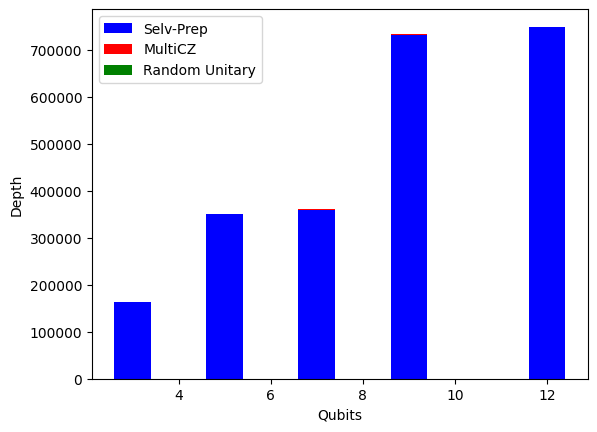

In [41]:
sizes = [3, 5, 7, 9, 12]
means = []

#redo random unitary for smaller sizes
for n in sizes:
    print(n)
    qubits = cirq.LineQubit.range(n)
    depths = []
    for i in range(1000):
        rand_u = sh.random_unitary_circ(0.1, qubits)
        rand_u_cops = cirq.align_left(qsp_decompose_once(qsp_decompose_once(rand_u)))
        randu_cliff_t = cirq.align_left(clifford_plus_t_direct_transform(rand_u_cops))

        randu_ct_depth = ran.get_gate_depth(randu_cliff_t)
        depths.append(randu_ct_depth)
    means.append(np.mean(depths))

# Multiply Selv-Prep by n_phi - 1 = 46, and MultiCZ by n_phi - 3 = 44 for 24 degree polynomial
sd_full = np.multiply(sp_depths, 46)
mczd_full = np.multiply(mcz_depths, 44)
plt.bar(sizes, sd_full, color='blue')
plt.bar(sizes, mczd_full, bottom=sd_full, color='red')
plt.bar(sizes, means, bottom=np.add(sd_full, mczd_full), color='green')
plt.xlabel('Qubits')
plt.ylabel('Depth')
plt.legend(['Selv-Prep', 'MultiCZ', 'Random Unitary'])
plt.show()